#### IBM Data Science Professional Certificate
# Capstone Project: 
## A geographical insight into the city of Santiago, Chile





## Introduction  

Chile is currently in second place of the countries with greatest income inequeality among the OECD's members. This income differences have led to a spatial inequality where there is a physical segregation of people due to their socioeconomic status. The most dramatic effect it is observed in Santiago, the capital of Chile and the biggest and most populated city in the country. 

In this project I will try to use machine learning methods in order to analyze how the inequality has affected the local venues and how different are the Santiago's comunes (neighbourhoods) in terms of their venues' diversity.

## Data  

In order to accomplish the defined goal I will use the following sources of information:  
- The list of comunes per region and their spatial coordinates (latitude and longitude) come from a public **Github** repository called [geo_chile](https://github.com/2x3-la/geo-chile) from *2x3-la*.  
- The venues, their category and location will be extracted using the **Foursquare API**.  
- The comunes from the urban part of the Metropolitan region were obtained from the [wiki page](https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile).  
- The value of the m2 in the different comunes were obtained from a [blog](https://www.buenainversion.cl/blog/valor-metro-cuadrado/).

### Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json
from geopy.geocoders import Nominatim
import requests
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

In [2]:
# Github repository containing the coordinates for every comune in the different regions of Chile
url = 'https://raw.githubusercontent.com/2x3-la/geo-chile/master/chile_with_regions.json'

In [3]:
# Download json file
!wget -q -O 'cl_data.json' https://raw.githubusercontent.com/2x3-la/geo-chile/master/chile_with_regions.json

In [4]:
# Open json file
with open('cl_data.json') as json_data:
    cl_data = json.load(json_data)


In [5]:
# Creating empty data frame
cols = ['Region', 'Comuna', 'Latitude', 'Longitude']

cl_df = pd.DataFrame(columns = cols)

In [6]:
# Fill data frame with values from json file

# Iterate through regions in the json file
for reg in cl_data:
    region = reg
    
    # Iterate through the info present in each region
    for data in cl_data[reg]: 
        comuna = data['name']
        lat = data['lat']
        lon = data['lng']
        
        # Append info extracted to data frame
        cl_df = cl_df.append({'Region': region,
                              'Comuna': comuna, 
                              'Latitude': lat, 
                              'Longitude': lon}, ignore_index = True)

In [7]:
# Changing datatype of Latitude and Longitud to a float
cl_df['Latitude'] = pd.to_numeric(cl_df['Latitude'], downcast = 'float')
cl_df['Longitude'] = pd.to_numeric(cl_df['Longitude'], downcast = 'float')

In [8]:
# Filter df for comunes only in the Metropolitan region
scl_df = cl_df[cl_df['Region'] == 'Metropolitana'].reset_index(drop = True)
scl_df.shape

(51, 4)

In [9]:
# Getting coordinates from santiago in order to map it
address = 'Santiago, Chile'
geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Santiago, Chile are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Santiago, Chile are -33.4377756, -70.6504502.


In [10]:
# Create map with the former coordinates 
map_scl = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add labels to map
for lat, lon, label in zip(scl_df['Latitude'], scl_df['Longitude'], scl_df['Comuna']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scl)  
    
map_scl

Because there are some comunes that are considered satelites in the Metroplolitan region that could cause noise to the analysis, due to their rural characteristic, therefore, I would consider only the urban ones.

In [11]:
url = 'https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile'

In [12]:
wiki_df = pd.read_html(url)[5]

In [13]:
scl_df = pd.merge(scl_df, wiki_df['Comuna'], how = 'inner', on = 'Comuna')
scl_df.shape

(35, 4)

In [14]:
# Create map with the former coordinates 
map_scl = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add labels to map
for lat, lon, label in zip(scl_df['Latitude'], scl_df['Longitude'], scl_df['Comuna']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scl)  
    
map_scl

In [15]:
# Foursquare credentials
CLIENT_ID = 'AWQT1QHMRZGO1NQPGIE0OTSZV0QOUYXNPJIQBUGUILLTUEPF' 
CLIENT_SECRET = 'GSJSPPUOKMKF10OKQFISH00FQUL34WORQLQGVYAG0JVSIV1V' 
VERSION = '20180605' 
LIMIT = 100

In [16]:
def getNearbyVenues(comuna, latitudes, longitudes, radius = 2000):
    
    venues_list=[]
    for comuna, lat, lon in zip(comuna, latitudes, longitudes):
            
        # Url for API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            comuna, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Comuna', 
                  'Comuna Latitude', 
                  'Comuna Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
scl_venues = getNearbyVenues(comuna = scl_df['Comuna'],
                             latitudes = scl_df['Latitude'],
                             longitudes = scl_df['Longitude'])

(2032, 7)


<function matplotlib.pyplot.show(close=None, block=None)>

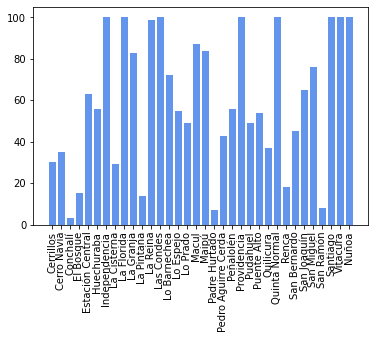

In [18]:
print(scl_venues.shape)
plt.bar(x = scl_venues.groupby('Comuna').count().index.values,
        height = scl_venues.groupby('Comuna').count()['Comuna Latitude'].values,
        color = 'cornflowerblue')
plt.xticks(rotation = 90)
plt.show

In [19]:
# Generate dummy values for the category of the venues
scl_dummy = pd.get_dummies(scl_venues[['Venue Category']], prefix="", prefix_sep="")

# Add Comuna to the first column
scl_dummy.insert(0, 'Comuna', scl_venues['Comuna'])


In [20]:
scl_grouped = scl_dummy.groupby('Comuna').mean().reset_index()

In [21]:
# set number of clusters
kclusters = 5

scl_clustering = scl_grouped.drop('Comuna', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scl_clustering)

# Add clustering labels to df
scl_grouped.insert(0, 'Cluster', kmeans.labels_)


In [22]:
scl_df_clusters = pd.merge(scl_df, scl_grouped.iloc[:,[0,1]], on = 'Comuna')



In [23]:
# Create map with clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set colors for clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add labels to map
markers_colors = []
for lat, lon, poi, cluster in zip(scl_df_clusters['Latitude'], scl_df_clusters['Longitude'], scl_df_clusters['Comuna'], scl_df_clusters['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Maybe the differences in the distribuition of venues per comune is affecting the clustering, so I will filter the data by the number of venues observed in each comune.

Text(0, 0.5, 'Number of comunes')

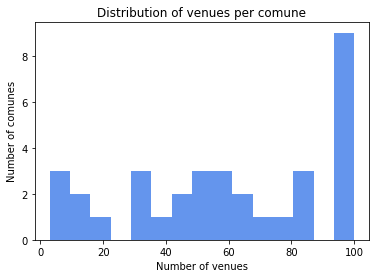

In [24]:
plt.hist(scl_venues.groupby('Comuna').count()['Comuna Latitude'],
         bins = 15, 
         color = 'cornflowerblue')
plt.title('Distribution of venues per comune')
plt.xlabel('Number of venues')
plt.ylabel('Number of comunes')

In [31]:
discriminant = scl_venues.groupby('Comuna').count()[scl_venues.groupby('Comuna').count()['Comuna Latitude'] > 40]
discriminant.reset_index(inplace = True)






In [26]:
scl_grouped = scl_grouped.drop('Cluster', 1)

In [33]:
scl_grouped = pd.merge(scl_grouped, discriminant.iloc[:,0], how = 'inner', on = 'Comuna')
scl_grouped.shape

(24, 253)